In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import warnings
from PIL import Image
from shutil import rmtree
warnings.filterwarnings('ignore')

2024-06-06 22:06:32.790103: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 22:06:32.820014: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 22:06:32.970915: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 22:06:33.993544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
path_original = '256X'
path_blurred = 'Zgaussowane'

# Funkcja do ładowania i przetwarzania obrazów
def load_images(path, size=(256, 256)):
    images = []
    for filename in sorted(os.listdir(path)):
        img_path = os.path.join(path, filename)
        img = load_img(img_path, target_size=size, color_mode='rgb')
        img = img_to_array(img) / 255.0  # Normalizacja obrazów do zakresu [0, 1]
        images.append(img)
    return np.array(images)

In [10]:
for sciezka in ['256X/.ipynb_checkpoints', 'Zgaussowane/.ipynb_checkpoints', 'Test_Gauss/.ipynb_checkpoints']:
    if os.path.isdir(sciezka):
        rmtree(sciezka)

In [4]:
original_images = load_images(path_original)
blurred_images = load_images(path_blurred)

print(f'Liczba załadowanych oryginalnych obrazów: {len(original_images)}')
print(f'Liczba załadowanych zblurowanych obrazów: {len(blurred_images)}')

Liczba załadowanych oryginalnych obrazów: 115
Liczba załadowanych zblurowanych obrazów: 115


In [5]:
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

input_shape = (256, 256, 3)
model = build_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,683 (1.28 MB)

 Trainable params: 335,683 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#def build_model(input_shape):
#    model = Sequential()
#    model.add(Input(shape=input_shape))
#    model.add(UpSampling2D((2, 2)))
#    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#    model.add(MaxPooling2D((2, 2)))
#    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
#    
#    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
#    return model
#
#input_shape = (256, 256, 3)
#model = build_model(input_shape)
#model.summary()

In [7]:
from sklearn.model_selection import train_test_split

ilosc_epok = 36
# Podział danych na treningowe i walidacyjne
X_train, X_val, y_train, y_val = train_test_split(blurred_images, original_images, random_state=42)

# Trenowanie modelu
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ilosc_epok, batch_size=8)

# Zapisywanie modelu
# model.save('deblur_cnn_model.h5')
keras.saving.save_model(model, f'deblur_cnn_model_redux{ilosc_epok}.keras')

Epoch 1/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 101s 9s/step - loss: 0.0814 - val_loss: 0.0593
Epoch 2/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 113s 10s/step - loss: 0.0482 - val_loss: 0.0261
Epoch 3/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 107s 10s/step - loss: 0.0194 - val_loss: 0.0102
Epoch 4/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 111s 10s/step - loss: 0.0119 - val_loss: 0.0085
Epoch 5/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 107s 10s/step - loss: 0.0085 - val_loss: 0.0070
Epoch 6/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - loss: 0.0068 - val_loss: 0.0060
Epoch 7/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 105s 10s/step - loss: 0.0065 - val_loss: 0.0055
Epoch 8/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 105s 10s/step - loss: 0.0051 - val_loss: 0.0052
Epoch 9/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 106s 10s/step - loss: 0.0053 - val_loss: 0.0048
Epoch 10/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 104s 10s/step - loss: 0.0049 - val_loss: 0.0049
Epoch 11/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 108s 10s/step - loss: 0.0044 - val_loss: 0.0052
Epoch 12/36
11/11 ━━━━━━━━━━━━━━━━━━━━ 109s 10s/step -

In [11]:
path_test = 'Test_Gauss/'
test_images = load_images(path_test)
X_test, y_test = train_test_split(test_images, random_state=42)

In [12]:
# model_path = 'deblur_cnn_model_redux.keras'
# keras.saving.load_model(model_path, custom_objects=None, compile=True, safe_mode=True)

In [13]:
import matplotlib.pyplot as plt

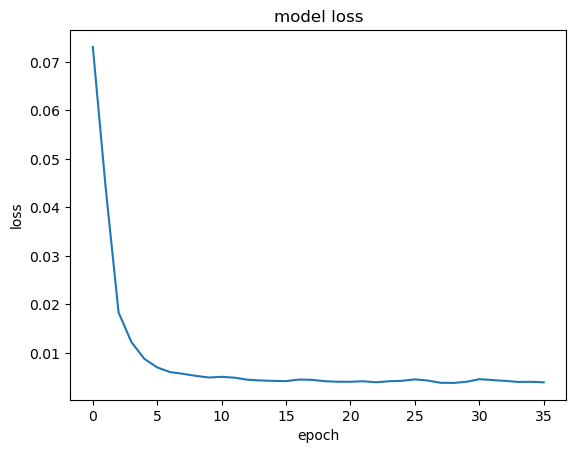

In [14]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [15]:
for i in range(5):
    restored_image = model.predict(np.expand_dims(X_val[i], axis=0))

    restored_image = restored_image[0] * 255
    restored_image = restored_image.astype('uint8')

    restored_image_pil = Image.fromarray(restored_image)
    restored_image_pil.save(f'Restored/{i}_{ilosc_epok}.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


In [16]:
for i in range(3):
    test_image = model.predict(np.expand_dims(X_test[i], axis=0))

    test_image = test_image[0] * 255
    test_image = test_image.astype('uint8')

    test_image_pil = Image.fromarray(test_image)
    test_image_pil.save(f'Restored/Test_{i}_{ilosc_epok}.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
